# Sprint 8 · Webinar 23 · Data Analytics teórico (Explorar conexiones con correlaciones)

**Programa:** Data Analytics  
**Sprint:** 8  
**Modalidad:** Teórica (con demostraciones en Python)  


## Fecha

**12 de enero de 2026**


## Objetivos de la sesión teórica

Al finalizar la sesión, el/la estudiante podrá:

1. Explicar qué es **correlación** y diferenciarla de **causalidad**.
2. Explorar relaciones entre variables usando visualizaciones (scatterplots, heatmaps, scatter matrix).
3. Calcular y comparar **correlaciones de Pearson y Spearman** e interpretar su resultado.
4. Elegir **métricas apropiadas** para analizar relaciones entre variables de distintos tipos (numéricas, categóricas, binarias, ordinales).
5. Identificar riesgos comunes de interpretación (confusión, causalidad inversa, **Simpson’s paradox**).
6. Redactar y comunicar hallazgos de correlación de forma ética, clara y accionable.


## Agenda sugerida (120 minutos)

| Tiempo | Bloque | Contenido | Modalidad |
|---:|---|---|---|
| 0–10 min | Calentamiento | ¿Qué significa “relación” en datos? ejemplos cotidianos | Discusión |
| 10–30 min | Dataset | Crear un dataset extenso y explorarlo rápidamente | Demo + práctica guiada |
| 30–55 min | 8.1 | Explorar relaciones visualmente (scatter, heatmaps, scatter matrix) | Demo + práctica |
| 55–85 min | 8.2 | Calcular correlaciones (Pearson/Spearman + tipos de variables) | Demo + preguntas |
| 85–100 min | Riesgos | Correlación ≠ causalidad + Simpson’s paradox | Discusión + demo |
| 100–112 min | Automatización | Funciones para automatizar análisis de correlación | Demo |
| 112–118 min | Comunicación | Ética + reporte de correlación + uso responsable de IA | Discusión + ejemplo |
| 118–120 min | Cierre | Takeaways + próximos pasos | Cierre |


## Ejercicio 0 · Calentamiento en breakout rooms (discusión conceptual, 10 min)

En equipos, conversen y respondan:

1. Den **2 ejemplos** donde dos variables estén relacionadas (en la vida real o en negocios).
2. ¿Qué significa que una relación sea **lineal**? ¿y **monótona**?
3. ¿Puede existir correlación alta sin causalidad? Den **un ejemplo**.
4. ¿Qué riesgos aparecen si reportamos correlaciones sin contexto?

> Objetivo: activar intuición y vocabulario (relación, correlación, causalidad, confusores).


## Ejercicio 1 · Crear y explorar un dataset extenso para análisis (20 min)

Vamos a crear un dataset sintético con múltiples tipos de variables para practicar:

- **Numéricas** (gasto, ingresos, tiempo en sitio, temperatura, etc.)
- **Binarias** (premium, convertido)
- **Categóricas** (canal, región, dispositivo, segmento)
- **Ordinales** (satisfacción 1–5)
- **Fecha** (semana)

El dataset está diseñado para incluir:
- Un caso de **confusión** (temperatura → ventas de helado y “drownings”).
- Un caso de **Simpson’s paradox** (gasto en marketing vs conversión al segmentar).

> Importante: el dataset es sintético; el objetivo es aprender el método, no “la verdad” del mundo real.


In [2]:
# ============================================================
# Imports y configuración (ejecuta esta celda primero)
# ============================================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

RANDOM_SEED = 42


In [3]:
# ============================================================
# Generación del dataset sintético para el Sprint 8
# ============================================================

def generate_sprint8_dataset(n_rows: int = 8000, seed: int = 42) -> pd.DataFrame:
    """
    Genera un dataset sintético para análisis de correlación y relaciones.

    Metas didácticas:
    - Incluir múltiples tipos de variables (numéricas, binarias, categóricas, ordinales, fecha).
    - Incluir un escenario de confusión:
        temperature -> ice_cream_sales y temperature -> drownings
    - Incluir un escenario de Simpson's paradox:
        marketing_spend_usd vs converted, al segmentar por 'segment'

    Parámetros
    ----------
    n_rows : int
        Número de filas.
    seed : int
        Semilla para reproducibilidad.

    Retorna
    -------
    pd.DataFrame
        Dataset sintético.
    """
    rng = np.random.default_rng(seed)

    # Tiempo (semanal)
    start = pd.Timestamp("2025-01-06")  # lunes
    weeks = pd.date_range(start, periods=104, freq="W-MON")  # ~2 años
    week = rng.choice(weeks, size=n_rows, replace=True)
    week_of_year = pd.to_datetime(week).isocalendar().week.astype(int).to_numpy()

    # Contexto categórico
    region = rng.choice(["Norte", "Centro", "Sur", "Oriente", "Occidente"], size=n_rows, p=[0.18, 0.28, 0.20, 0.17, 0.17])
    channel = rng.choice(["Orgánico", "Paid Search", "Social", "Email", "Referidos"], size=n_rows, p=[0.30, 0.28, 0.18, 0.14, 0.10])
    device = rng.choice(["Mobile", "Desktop", "Tablet"], size=n_rows, p=[0.62, 0.33, 0.05])

    # Clientes (repetidos)
    customer_id = rng.integers(1, 2001, size=n_rows)
    age = np.clip(rng.normal(34, 11, size=n_rows).round().astype(int), 18, 70)
    income = np.clip(rng.lognormal(mean=10.5, sigma=0.45, size=n_rows), 12000, 220000)  # ingreso anual
    is_premium = rng.choice([0, 1], size=n_rows, p=[0.78, 0.22])

    # Confusión: estacionalidad -> temperatura -> (helados, drownings)
    temperature_c = 24 + 6 * np.sin(2 * np.pi * (week_of_year / 52.0)) + rng.normal(0, 1.8, size=n_rows)
    ice_cream_sales = np.clip(200 + 16 * temperature_c + rng.normal(0, 40, size=n_rows), 0, None)
    drownings = np.clip(3 + 0.18 * temperature_c + rng.normal(0, 1.2, size=n_rows), 0, None)

    # Segmento (para Simpson)
    segment = rng.choice(["SMB", "Enterprise"], size=n_rows, p=[0.70, 0.30])

    # Marketing spend (segmento + canal)
    channel_uplift = pd.Series(channel).map({"Orgánico": 0.7, "Paid Search": 1.4, "Social": 1.1, "Email": 0.9, "Referidos": 0.6}).to_numpy()
    base_spend = np.where(segment == "Enterprise", 320, 90)
    marketing_spend_usd = np.clip(base_spend * channel_uplift + rng.normal(0, 35, size=n_rows), 0, None)

    # Engagement (relación no lineal con spend)
    sessions = np.clip((0.9 * np.sqrt(marketing_spend_usd) + rng.normal(0, 3, size=n_rows)), 0, None).round().astype(int)
    pages_viewed = np.clip((sessions * rng.normal(3.2, 0.6, size=n_rows) + rng.normal(0, 4, size=n_rows)), 1, None).round().astype(int)
    time_on_site_sec = np.clip((pages_viewed * rng.normal(26, 7, size=n_rows) + rng.normal(0, 60, size=n_rows)), 20, None)

    # Descuentos
    discount_pct = np.clip(rng.normal(12, 8, size=n_rows), 0, 40)

    # Conversión (probabilidad logística)
    seg_mean_spend = np.where(segment == "Enterprise", 320, 90)
    spend_centered = marketing_spend_usd - seg_mean_spend

    logit = (
        -2.2
        + 0.35 * is_premium
        + 0.05 * np.log1p(pages_viewed)
        + 0.03 * discount_pct
        + np.where(segment == "Enterprise", 0.8, -0.2)
        - 0.0032 * spend_centered  # dentro de segmento: leve relación negativa con spend
        + rng.normal(0, 0.35, size=n_rows)
    )

    conv_prob = 1 / (1 + np.exp(-logit))
    converted = (rng.random(n_rows) < conv_prob).astype(int)

    # Orders y revenue
    orders = np.where(converted == 1, np.clip(rng.poisson(1.15, size=n_rows), 1, 5), 0)
    base_aov = np.where(is_premium == 1, rng.normal(150, 40, size=n_rows), rng.normal(95, 28, size=n_rows))
    avg_order_value_usd = np.clip(base_aov * (1 - discount_pct / 120) + rng.normal(0, 10, size=n_rows), 15, None)
    revenue_usd = orders * avg_order_value_usd

    # Experiencia: delivery y tickets
    delivery_time_days = np.clip(rng.normal(3.2, 1.4, size=n_rows) + np.where(region == "Oriente", 0.8, 0.0), 0.5, 12)
    support_tickets = np.clip(rng.poisson(0.35 + 0.25 * (delivery_time_days > 5), size=n_rows), 0, None)

    # Satisfacción (ordinal 1–5)
    sat_latent = (
        3.8
        + 0.5 * is_premium
        - 0.22 * delivery_time_days
        - 0.35 * support_tickets
        + 0.08 * np.log1p(revenue_usd)
        + rng.normal(0, 0.55, size=n_rows)
    )
    satisfaction_1_5 = np.clip(np.round(sat_latent), 1, 5).astype(int)

    # Churn risk (0–1)
    churn_logit = (
        0.8
        - 0.75 * (satisfaction_1_5 - 3)
        + 0.28 * support_tickets
        + 0.10 * (delivery_time_days - 3)
        + rng.normal(0, 0.35, size=n_rows)
    )
    churn_risk = 1 / (1 + np.exp(-churn_logit))

    df = pd.DataFrame({
        "week": pd.to_datetime(week),
        "customer_id": customer_id,
        "region": region,
        "segment": segment,
        "channel": channel,
        "device": device,
        "age": age,
        "income_usd": np.round(income, 2),
        "is_premium": is_premium,
        "temperature_c": np.round(temperature_c, 2),
        "ice_cream_sales": np.round(ice_cream_sales, 0).astype(int),
        "drownings": np.round(drownings, 2),
        "marketing_spend_usd": np.round(marketing_spend_usd, 2),
        "sessions": sessions,
        "pages_viewed": pages_viewed,
        "time_on_site_sec": np.round(time_on_site_sec, 0).astype(int),
        "discount_pct": np.round(discount_pct, 2),
        "converted": converted,
        "orders": orders,
        "avg_order_value_usd": np.round(avg_order_value_usd, 2),
        "revenue_usd": np.round(revenue_usd, 2),
        "delivery_time_days": np.round(delivery_time_days, 2),
        "support_tickets": support_tickets,
        "satisfaction_1_5": satisfaction_1_5,
        "churn_risk": np.round(churn_risk, 4),
    })

    return df.sort_values(["week", "customer_id"]).reset_index(drop=True)

df = generate_sprint8_dataset(n_rows=8000, seed=RANDOM_SEED)
df.head()


,week,customer_id,region,segment,channel,device,age,income_usd,is_premium,temperature_c,ice_cream_sales,drownings,marketing_spend_usd,sessions,pages_viewed,time_on_site_sec,discount_pct,converted,orders,avg_order_value_usd,revenue_usd,delivery_time_days,support_tickets,satisfaction_1_5,churn_risk
0,2025-01-06,72,Centro,SMB,Social,Desktop,39,19225.68,0,29.94,706,9.88,105.04,13,37,850,24.52,0,0,85.74,0.0,4.05,0,4,0.5613
1,2025-01-06,120,Sur,SMB,Paid Search,Mobile,30,34497.10,0,25.09,587,8.07,163.22,11,41,839,26.68,0,0,24.32,0.0,3.04,0,3,0.6581
2,2025-01-06,124,Occidente,SMB,Email,Mobile,25,17252.23,0,26.67,525,9.16,64.98,13,43,1346,12.39,0,0,99.69,0.0,4.26,1,3,0.7726
3,2025-01-06,148,Centro,SMB,Orgánico,Mobile,37,48057.44,0,24.44,600,6.04,62.89,12,40,1216,11.73,0,0,58.74,0.0,3.54,1,3,0.6644
4,2025-01-06,195,Occidente,Enterprise,Social,Desktop,18,34162.57,0,26.39,577,8.63,365.01,18,81,2303,18.84,0,0,101.24,0.0,3.25,1,3,0.6749


In [4]:
# Guardar el dataset a CSV (para usarlo en ejercicios o compartirlo)

csv_path = "sprint8_webinar23_correlations_dataset.csv"
#df.to_csv(csv_path, index=False)

print("CSV guardado en:", csv_path)


CSV guardado en: sprint8_webinar23_correlations_dataset.csv


In [5]:
# Exploración rápida (EDA mínima)

print("Forma (filas, columnas):", df.shape)
display(df.sample(5, random_state=RANDOM_SEED))



Forma (filas, columnas): (8000, 25)


,week,customer_id,region,segment,channel,device,age,income_usd,is_premium,temperature_c,ice_cream_sales,drownings,marketing_spend_usd,sessions,pages_viewed,time_on_site_sec,discount_pct,converted,orders,avg_order_value_usd,revenue_usd,delivery_time_days,support_tickets,satisfaction_1_5,churn_risk
2215,2025-07-21,700,Norte,SMB,Orgánico,Desktop,23,17680.96,1,22.04,585,8.23,56.31,10,22,593,15.49,0,0,183.24,0.0,1.45,0,4,0.3505
2582,2025-08-18,1598,Centro,SMB,Orgánico,Mobile,27,55737.21,1,18.90,452,6.07,109.79,11,50,875,2.41,0,0,130.19,0.0,3.43,0,3,0.6875
1662,2025-06-02,33,Centro,SMB,Email,Mobile,25,27398.83,0,28.72,658,8.59,107.65,10,34,727,13.84,0,0,107.50,0.0,1.76,0,3,0.5378
3027,2025-09-29,1234,Centro,SMB,Social,Mobile,18,71260.46,0,19.77,510,6.39,135.38,8,25,942,19.24,0,0,110.05,0.0,5.60,0,2,0.8780
4343,2026-01-26,842,Oriente,SMB,Referidos,Mobile,23,21020.00,0,26.74,619,7.42,75.22,15,41,438,12.20,0,0,98.28,0.0,6.72,2,3,0.8810


In [6]:
print("\nTipos de datos:")
display(df.dtypes)


Tipos de datos:


week                   datetime64[ns]
customer_id                     int64
region                         object
segment                        object
channel                        object
device                         object
age                             int64
income_usd                    float64
is_premium                      int64
temperature_c                 float64
ice_cream_sales                 int64
drownings                     float64
marketing_spend_usd           float64
sessions                        int64
pages_viewed                    int64
time_on_site_sec                int64
discount_pct                  float64
converted                       int64
orders                          int64
avg_order_value_usd           float64
revenue_usd                   float64
delivery_time_days            float64
support_tickets                 int64
satisfaction_1_5                int64
churn_risk                    float64
dtype: object

In [7]:
print("\nResumen de variables numéricas:")
display(df.select_dtypes(include="number").describe())


Resumen de variables numéricas:


,customer_id,age,income_usd,is_premium,temperature_c,ice_cream_sales,drownings,marketing_spend_usd,sessions,pages_viewed,time_on_site_sec,discount_pct,converted,orders,avg_order_value_usd,revenue_usd,delivery_time_days,support_tickets,satisfaction_1_5,churn_risk
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000
mean,1001.678500,34.253125,39875.343680,0.218250,24.021373,584.495750,7.308190,154.355780,10.301500,33.08225,861.437500,12.239128,0.201500,0.288500,96.201151,28.34254,3.356193,0.390625,3.113875,0.680665
std,575.837431,10.357471,18631.154318,0.413084,4.573329,83.556063,1.465358,122.734853,5.204155,18.37643,549.834481,7.674640,0.401146,0.672551,36.964865,71.13456,1.396528,0.630941,0.777646,0.154265
min,1.000000,18.000000,12000.000000,0.000000,12.890000,328.000000,1.900000,0.000000,0.000000,1.00000,20.000000,0.000000,0.000000,0.000000,15.000000,0.00000,0.500000,0.000000,1.000000,0.149600
25%,500.000000,27.000000,26778.382500,0.000000,20.117500,520.000000,6.310000,69.005000,7.000000,20.00000,463.000000,6.470000,0.000000,0.000000,70.990000,0.00000,2.400000,0.000000,3.000000,0.576175
50%,999.000000,34.000000,35976.330000,0.000000,23.990000,585.000000,7.290000,111.900000,10.000000,31.00000,772.000000,12.015000,0.000000,0.000000,92.170000,0.00000,3.340000,0.000000,3.000000,0.700350
75%,1496.000000,41.000000,48767.825000,0.000000,27.950000,649.000000,8.320000,204.872500,14.000000,44.00000,1163.250000,17.462500,0.000000,0.000000,117.052500,0.00000,4.310000,1.000000,4.000000,0.797400
max,2000.000000,70.000000,220000.000000,1.000000,35.340000,849.000000,13.170000,546.460000,30.000000,127.00000,4289.000000,40.000000,1.000000,5.000000,324.640000,734.40000,8.930000,5.000000,5.000000,0.980800


In [8]:
print("\nValores faltantes (por columna):")
display(df.isna().sum().sort_values(ascending=False).head(10))


Valores faltantes (por columna):


week             0
customer_id      0
region           0
segment          0
channel          0
device           0
age              0
income_usd       0
is_premium       0
temperature_c    0
dtype: int64

### Preguntas guiadas para el Ejercicio 1

1. ¿Cuántas filas y columnas tiene el dataset?
2. ¿Qué variables parecen **numéricas** vs **categóricas** vs **ordinales**?
3. ¿Hay valores faltantes? ¿Qué harías si existieran?
4. ¿Qué variables crees que deberían estar relacionadas? (hipótesis)


## 8.1 Exploring Relationships Visually

Antes de calcular correlaciones, suele ser mejor **mirar** los datos:

- Una correlación alta puede esconder **no linealidad**, **outliers** o **subgrupos**.
- Un scatterplot puede revelar relaciones que un número no resume bien.
- Visualizar también ayuda a evitar interpretaciones erróneas.


### 8.1.1 Understanding Lineal Correlation & Relationships

**Correlación lineal**: mide qué tanto dos variables se mueven juntas en forma (aprox.) lineal.

- **Dirección**: positiva (sube/sube) vs negativa (sube/baja).
- **Fuerza**: cerca de 1 o -1 es fuerte; cerca de 0 es débil (linealmente).
- **Linealidad vs monotonicidad**:
  - *Lineal*: puntos cercanos a una línea.
  - *Monótona*: “sube en general” aunque no sea recta (Spearman suele captarla mejor).

> Consejo: si sospechas relación **curva** o **monótona**, no confíes solo en Pearson.


In [9]:
# Ejemplo visual 1: relación en el tiempo (líneas)
# Vamos a agregar por semana para visualizar tendencia.

weekly = (
    df.groupby("week", as_index=False)
      .agg(
          marketing_spend_usd=("marketing_spend_usd", "mean"),
          revenue_usd=("revenue_usd", "mean"),
          sessions=("sessions", "mean"),
          temperature_c=("temperature_c", "mean")
      )
)

display(weekly.head())

,week,marketing_spend_usd,revenue_usd,sessions,temperature_c
0,2025-01-06,144.392963,20.071605,9.950617,25.599383
1,2025-01-13,151.278254,15.344603,10.365079,26.297302
2,2025-01-20,179.002113,16.529859,11.830986,26.680986
3,2025-01-27,129.108625,23.592125,8.937500,27.404750
4,2025-02-03,148.420800,31.107600,9.920000,28.276933


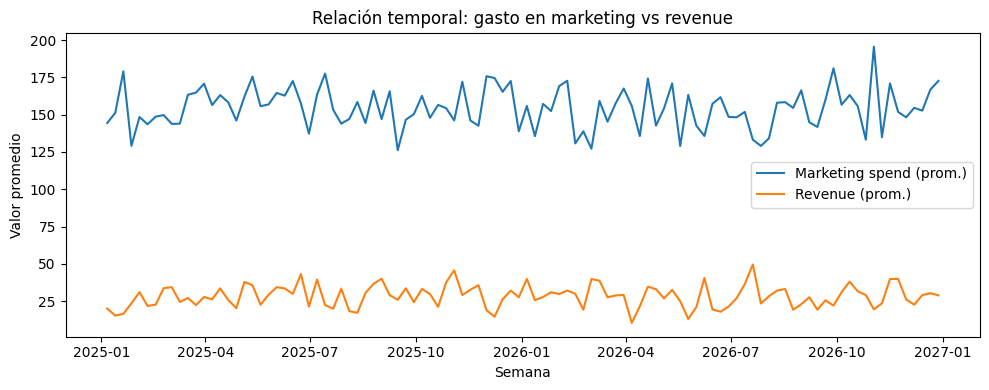

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(weekly["week"], weekly["marketing_spend_usd"], label="Marketing spend (prom.)")
plt.plot(weekly["week"], weekly["revenue_usd"], label="Revenue (prom.)")
plt.title("Relación temporal: gasto en marketing vs revenue")
plt.xlabel("Semana")
plt.ylabel("Valor promedio")
plt.legend()
plt.tight_layout()
plt.show()

### 8.1.2 Scatterplots for Relationships

El **scatterplot** (diagrama de dispersión) es la herramienta estándar para ver relaciones entre dos variables numéricas:

- Detecta **tendencias** (positiva/negativa).
- Identifica **outliers** (puntos extremos).
- Revela **subgrupos** si coloreamos por una variable categórica (hue).

Opcionalmente, podemos agregar una línea de tendencia para apoyar la interpretación (sin confundir con causalidad).


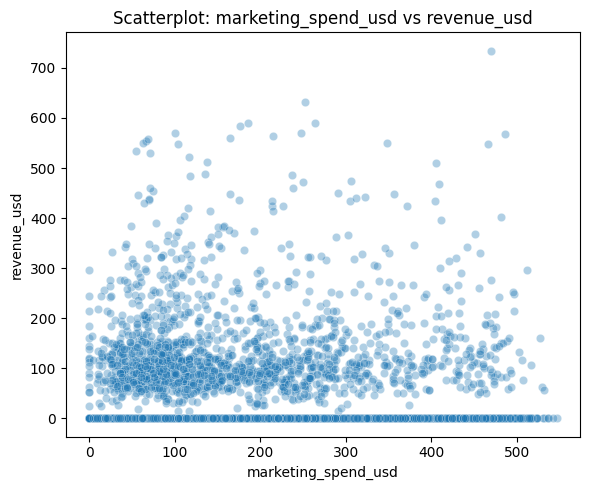

In [11]:
# Scatterplot 1: spend vs revenue
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df, x="marketing_spend_usd", y="revenue_usd", alpha=0.35)
plt.title("Scatterplot: marketing_spend_usd vs revenue_usd")
plt.tight_layout()
plt.show()

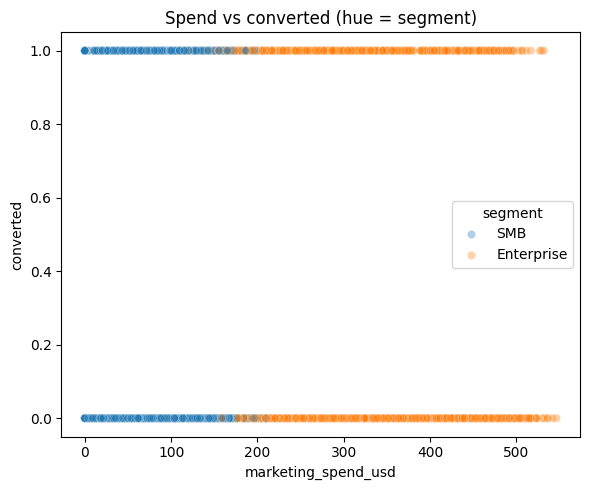

In [12]:
# Scatterplot 2: colorear por segmento (para ver subgrupos)
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df, x="marketing_spend_usd", y="converted", hue="segment", alpha=0.35)
plt.title("Spend vs converted (hue = segment)")
plt.tight_layout()
plt.show()


### 8.1.3 Multi-Variable Relationships: Heatmaps & Scatter Matrix

Cuando tenemos varias variables numéricas:

- **Heatmap**: resume muchas correlaciones de una vez.
- **Scatter matrix**: muestra la “nube” de puntos para varios pares (útil para detectar no linealidad y outliers).

> Tip: empieza con 6–10 variables clave (si pones 30, se vuelve ilegible).


In [13]:
# Selecciona un subconjunto razonable de variables numéricas
num_cols = [
    "marketing_spend_usd", "sessions", "pages_viewed", "time_on_site_sec",
    "discount_pct", "orders", "avg_order_value_usd", "revenue_usd",
    "delivery_time_days", "support_tickets", "satisfaction_1_5", "churn_risk",
    "temperature_c", "ice_cream_sales", "drownings"
]

corr = df[num_cols].corr(numeric_only=True)

In [30]:
df[num_cols].corr(numeric_only=True)

,marketing_spend_usd,sessions,pages_viewed,time_on_site_sec,discount_pct,orders,avg_order_value_usd,revenue_usd,delivery_time_days,support_tickets,satisfaction_1_5,churn_risk,temperature_c,ice_cream_sales,drownings
marketing_spend_usd,1.000000,0.795929,0.718803,0.629067,-0.003066,0.097379,-0.012298,0.096423,0.016341,0.000590,-0.012723,0.008474,-0.000225,-0.006604,0.005990
sessions,0.795929,1.000000,0.901840,0.787592,-0.002138,0.086371,-0.004939,0.087118,0.012924,0.006998,-0.010215,0.011630,0.003375,-0.005170,0.013574
pages_viewed,0.718803,0.901840,1.000000,0.869310,-0.006610,0.079376,-0.003739,0.080571,0.013426,0.015375,-0.007050,0.010592,0.014323,0.002548,0.017936
time_on_site_sec,0.629067,0.787592,0.869310,1.000000,-0.001988,0.063781,-0.000584,0.065550,0.012897,0.006052,-0.010392,0.010308,0.012005,0.003051,0.013042
discount_pct,-0.003066,-0.002138,-0.006610,-0.001988,1.000000,0.063533,-0.194540,0.026634,0.013663,-0.006613,0.008553,-0.008063,0.001119,-0.007199,-0.002555
orders,0.097379,0.086371,0.079376,0.063781,0.063533,1.000000,0.023674,0.925161,0.003743,-0.000460,0.188878,-0.143415,-0.002500,-0.000210,0.004258
avg_order_value_usd,-0.012298,-0.004939,-0.003739,-0.000584,-0.194540,0.023674,1.000000,0.174651,0.009215,0.010446,0.147056,-0.109511,0.002024,-0.000639,0.008596
revenue_usd,0.096423,0.087118,0.080571,0.065550,0.026634,0.925161,0.174651,1.000000,0.003950,-0.002896,0.205265,-0.155717,-0.002630,-0.000848,0.002684
delivery_time_days,0.016341,0.012924,0.013426,0.012897,0.013663,0.003743,0.009215,0.003950,1.000000,0.082535,-0.419617,0.492020,-0.013878,-0.016332,-0.004299
support_tickets,0.000590,0.006998,0.015375,0.006052,-0.006613,-0.000460,0.010446,-0.002896,0.082535,1.000000,-0.301643,0.402741,0.001867,0.000419,-0.010492


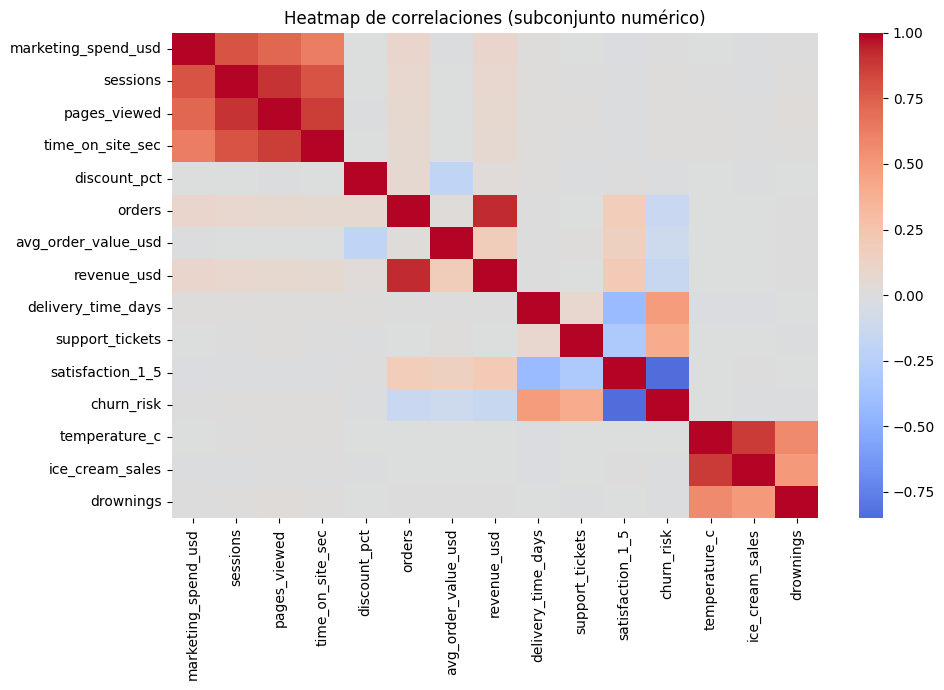

In [14]:
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Heatmap de correlaciones (subconjunto numérico)")
plt.tight_layout()
plt.show()


In [15]:
# Scatter matrix (puede tardar un poco). Usamos un sample para que sea más rápido.
from pandas.plotting import scatter_matrix

sample = df[num_cols].sample(600, random_state=RANDOM_SEED)

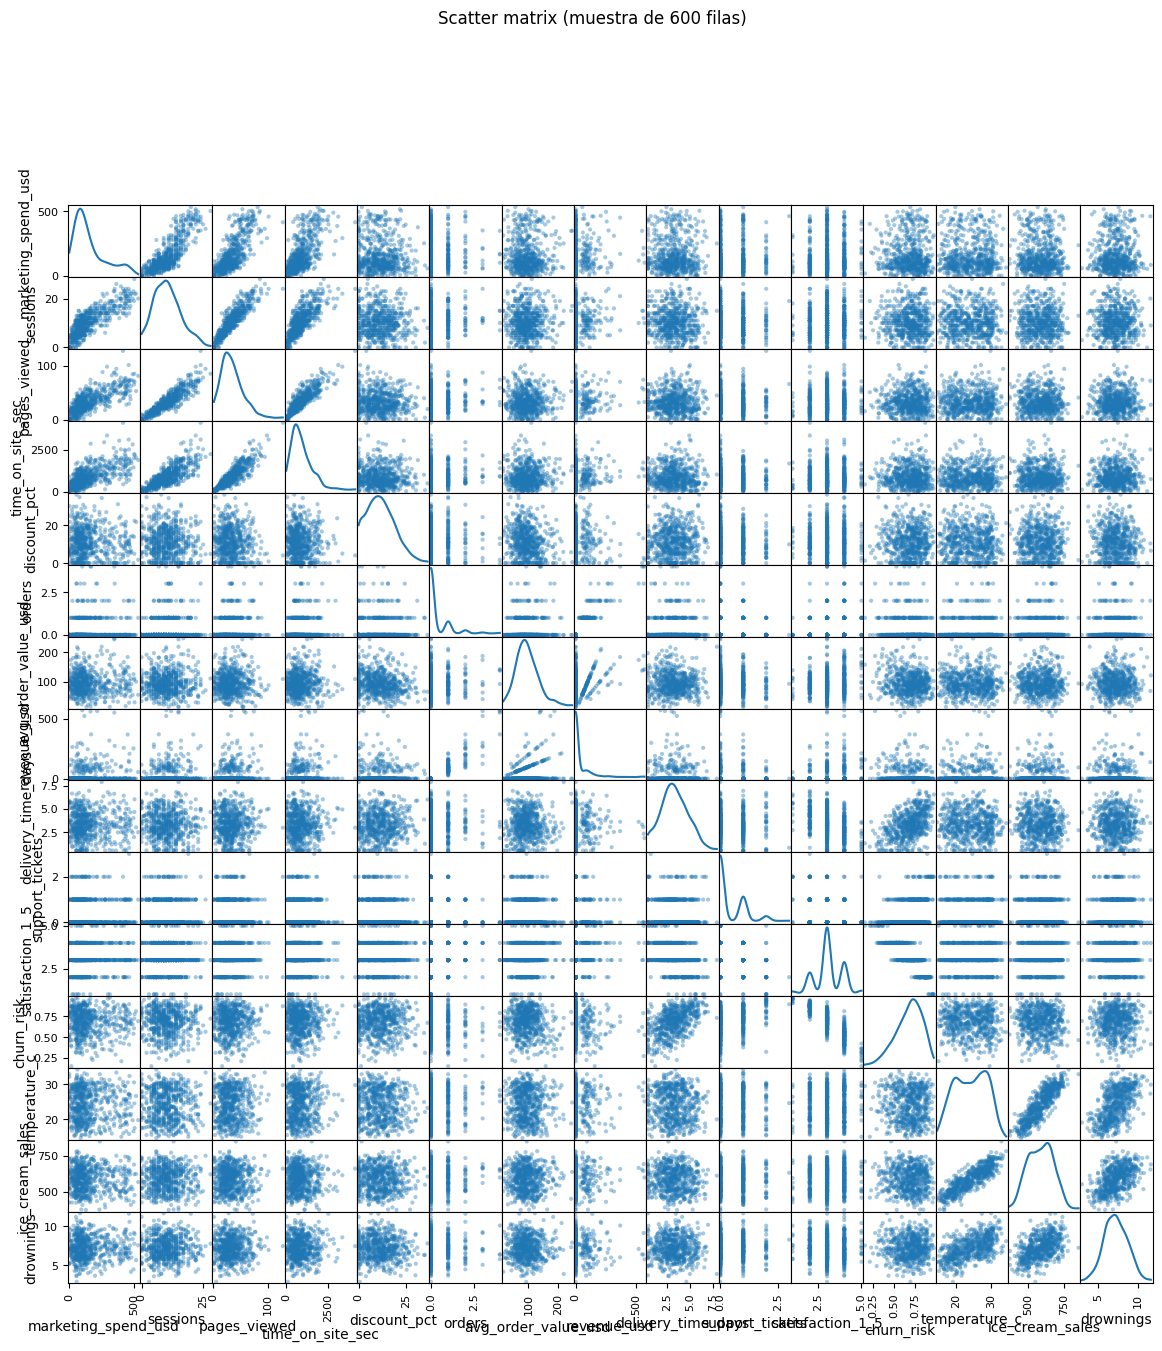

In [16]:
axes = scatter_matrix(sample, figsize=(14, 14), diagonal="kde", alpha=0.4)
plt.suptitle("Scatter matrix (muestra de 600 filas)", y=1.02)
plt.show()

### Mini-ejercicio (5 min)

1. Elige **2 variables** (numéricas) y crea un scatterplot.
2. ¿Ves relación lineal, monótona o ninguna?
3. ¿Hay outliers? ¿Cómo podrían afectar la correlación?


## 8.2 Calculating Correlations

Una vez exploradas las relaciones visualmente, podemos cuantificarlas.

Recordatorio:
- Un coeficiente de correlación es un **resumen**.
- Siempre debe acompañarse de **contexto**, **gráficos** y (cuando aplique) **segmentación**.


### 8.2.1 Pearson and Spearman Correlations

- **Pearson**: mide relación **lineal** entre variables numéricas.
- **Spearman**: mide relación **monótona** basada en rangos (más robusta a outliers y no linealidad suave).

Interpretación del coeficiente \(r\):
- \(r \approx 1\): relación positiva fuerte.
- \(r \approx -1\): relación negativa fuerte.
- \(r \approx 0\): relación lineal débil o inexistente.

> Nota: “\(r=0\)” NO significa “no hay relación” si la relación es no lineal.


In [17]:
# Pearson vs Spearman para un par de variables

x = df["pages_viewed"]
y = df["revenue_usd"]

pearson_r, pearson_p = stats.pearsonr(x, y)
spearman_r, spearman_p = stats.spearmanr(x, y)

print("pages_viewed vs revenue_usd")
print(f"Pearson  r = {pearson_r:.3f} | p-value = {pearson_p:.3e}")
print(f"Spearman r = {spearman_r:.3f} | p-value = {spearman_p:.3e}")

pages_viewed vs revenue_usd
Pearson  r = 0.081 | p-value = 5.310e-13
Spearman r = 0.086 | p-value = 1.282e-14


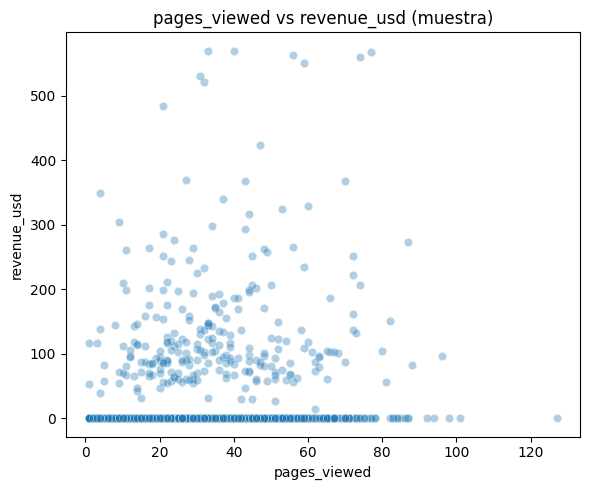

In [18]:
# Visual simple
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df.sample(1200, random_state=RANDOM_SEED), x="pages_viewed", y="revenue_usd", alpha=0.35)
plt.title("pages_viewed vs revenue_usd (muestra)")
plt.tight_layout()
plt.show()

### 8.2.2 Correlación entre distintos tipos de variables

No todas las variables son numéricas continuas. Para escoger una medida adecuada, piensa:

1. **Tipo de variable A** (numérica / categórica / binaria / ordinal)
2. **Tipo de variable B**
3. ¿Buscas relación **lineal**, **monótona**, o **dependencia** en general?

Métricas comunes (nivel introductorio):

- Numérica ↔ Numérica: **Pearson** (lineal) / **Spearman** (monótona)  
- Numérica ↔ Binaria: **Point-biserial**  
- Numérica ↔ Categórica (k>2): **Correlation ratio (η)** (tamaño de efecto)  
- Categórica ↔ Categórica: **Cramér’s V** (basada en χ²)  
- Ordinal ↔ Ordinal: **Spearman** o **Kendall τ**  

> En esta sesión no buscamos “la métrica perfecta”, sino aprender a escoger una opción razonable y reportarla con claridad.


In [19]:
# Funciones sencillas para correlación según tipos de variables

def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """Cramér's V para dos variables categóricas."""
    confusion = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    r, k = confusion.shape

    # Corrección de sesgo (opcional pero útil en tablas pequeñas)
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    return np.sqrt(phi2corr / max(1e-12, min((kcorr-1), (rcorr-1))))

def correlation_ratio(categories: pd.Series, values: pd.Series) -> float:
    """Correlation ratio (η) para categórica -> numérica."""
    df_tmp = pd.DataFrame({"cat": categories, "val": values}).dropna()
    if df_tmp["cat"].nunique() < 2:
        return np.nan

    grand_mean = df_tmp["val"].mean()
    ss_between = df_tmp.groupby("cat")["val"].count().mul((df_tmp.groupby("cat")["val"].mean() - grand_mean) ** 2).sum()
    ss_total = ((df_tmp["val"] - grand_mean) ** 2).sum()

    return np.sqrt(ss_between / ss_total) if ss_total > 0 else np.nan


In [20]:
# Ejemplos:
# 1) Numérica vs Binaria: point-biserial
r_pb, p_pb = stats.pointbiserialr(df["converted"], df["revenue_usd"])
print(f"Point-biserial (converted vs revenue_usd): r={r_pb:.3f}, p={p_pb:.3e}")


Point-biserial (converted vs revenue_usd): r=0.793, p=0.000e+00


In [21]:
# 2) Categórica (k>2) vs Numérica: correlation ratio (η)
eta = correlation_ratio(df["channel"], df["revenue_usd"])
print(f"Correlation ratio η (channel -> revenue_usd): eta={eta:.3f}")

Correlation ratio η (channel -> revenue_usd): eta=0.028


In [22]:
# 3) Categórica vs Categórica: Cramér's V
v = cramers_v(df["device"], df["channel"])
print(f"Cramér's V (device vs channel): V={v:.3f}")

Cramér's V (device vs channel): V=0.000


In [23]:
# 4) Ordinal vs Numérica: Spearman (tratando ordinal como ranks)
rho, p = stats.spearmanr(df["satisfaction_1_5"], df["churn_risk"])
print(f"Spearman (satisfaction_1_5 vs churn_risk): rho={rho:.3f}, p={p:.3e}")

Spearman (satisfaction_1_5 vs churn_risk): rho=-0.851, p=0.000e+00


### 8.2.3 Avoiding Misinterpretations (Correlation not equal Causation)

**Correlación ≠ causalidad.** Razones típicas:

- **Confusor**: una tercera variable explica parte (o toda) la relación.
- **Causalidad inversa**: Y causa X, no al revés.
- **Coincidencia / espurias**: relaciones por azar o por estacionalidad.
- **Selección**: el muestreo introduce sesgos (población no representativa).

Demostración: *ice_cream_sales* y *drownings* están correlacionadas, pero ambas suben con *temperature_c*.


In [24]:
# Correlación espuria por confusión: helados vs drownings

r_xy, _ = stats.pearsonr(df["ice_cream_sales"], df["drownings"])
r_xt, _ = stats.pearsonr(df["ice_cream_sales"], df["temperature_c"])
r_yt, _ = stats.pearsonr(df["drownings"], df["temperature_c"])

print(f"Pearson(ice_cream_sales, drownings)   = {r_xy:.3f}")
print(f"Pearson(ice_cream_sales, temperature)= {r_xt:.3f}")
print(f"Pearson(drownings, temperature)      = {r_yt:.3f}")

Pearson(ice_cream_sales, drownings)   = 0.497
Pearson(ice_cream_sales, temperature)= 0.876
Pearson(drownings, temperature)      = 0.572


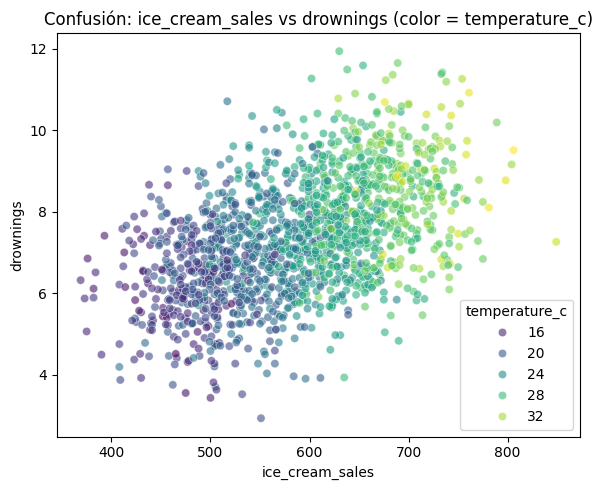

In [25]:
# Visualizar el patrón
sample = df.sample(1500, random_state=RANDOM_SEED)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=sample, x="ice_cream_sales", y="drownings", hue="temperature_c", palette="viridis", alpha=0.6)
plt.title("Confusión: ice_cream_sales vs drownings (color = temperature_c)")
plt.tight_layout()
plt.show()

In [26]:
# Estratificar por 'bins' de temperatura para ver que la relación se debilita dentro de grupos
bins = pd.cut(df["temperature_c"], bins=5)
within = df.groupby(bins).apply(lambda g: stats.pearsonr(g["ice_cream_sales"], g["drownings"])[0]).rename("pearson_within_bin")
display(within)

C:\Users\jeanp\AppData\Local\Temp\ipykernel_7444\1116059537.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  within = df.groupby(bins).apply(lambda g: stats.pearsonr(g["ice_cream_sales"], g["drownings"])[0]).rename("pearson_within_bin")


temperature_c
(12.868, 17.38]    0.022017
(17.38, 21.87]     0.072909
(21.87, 26.36]     0.054731
(26.36, 30.85]     0.081294
(30.85, 35.34]     0.070916
Name: pearson_within_bin, dtype: float64

### 8.2.4 Understanding Simpson's Paradox

**Simpson’s paradox** ocurre cuando:

- Una relación (o tendencia) aparece en el total,
- Pero al dividir por un **subgrupo** relevante, la tendencia cambia o se invierte.

En el dataset:
- `segment` (SMB vs Enterprise) cambia el comportamiento base.
- La relación global entre `marketing_spend_usd` y `converted` puede diferir de la relación por segmento.

> Moraleja: segmentar puede ser crítico antes de concluir.


In [27]:
# Simpson's paradox: spend vs conversion (global vs por segmento)

# Convertimos converted (0/1) en "tasa" por bins de spend para visualizar
df_tmp = df.copy()
df_tmp["spend_bin"] = pd.qcut(df_tmp["marketing_spend_usd"], q=10, duplicates="drop")

overall = df_tmp.groupby("spend_bin")["converted"].mean()
by_segment = df_tmp.groupby(["segment", "spend_bin"])["converted"].mean().reset_index()

display(overall.head())
display(by_segment.head())

C:\Users\jeanp\AppData\Local\Temp\ipykernel_7444\3165359462.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overall = df_tmp.groupby("spend_bin")["converted"].mean()
C:\Users\jeanp\AppData\Local\Temp\ipykernel_7444\3165359462.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_segment = df_tmp.groupby(["segment", "spend_bin"])["converted"].mean().reset_index()


spend_bin
(-0.001, 39.61]     0.171036
(39.61, 60.13]      0.160200
(60.13, 78.001]     0.161250
(78.001, 94.254]    0.178750
(94.254, 111.9]     0.152310
Name: converted, dtype: float64

,segment,spend_bin,converted
0,Enterprise,"(-0.001, 39.61]",NaN
1,Enterprise,"(39.61, 60.13]",NaN
2,Enterprise,"(60.13, 78.001]",NaN
3,Enterprise,"(78.001, 94.254]",1.0
4,Enterprise,"(94.254, 111.9]",1.0


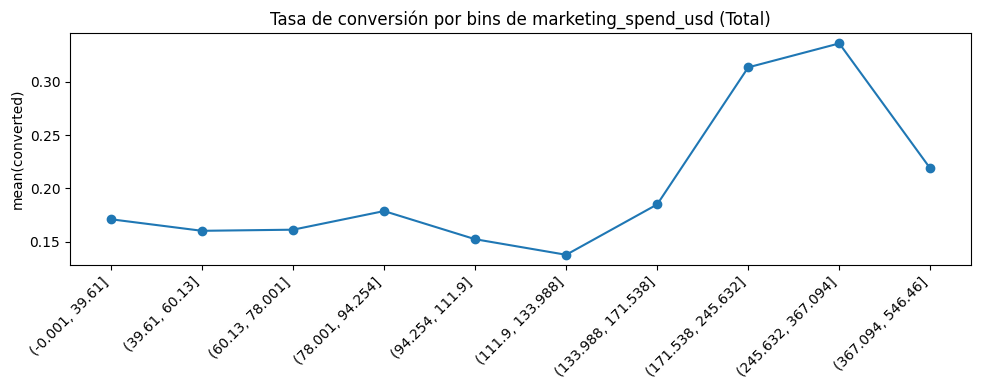

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(overall.index.astype(str), overall.values, marker="o", label="Total")
plt.xticks(rotation=45, ha="right")
plt.title("Tasa de conversión por bins de marketing_spend_usd (Total)")
plt.ylabel("mean(converted)")
plt.tight_layout()
plt.show()


In [31]:
# Correlación simple (Pearson) total vs por segmento
r_total, _ = stats.pearsonr(df["marketing_spend_usd"], df["converted"])
r_smb, _ = stats.pearsonr(df[df["segment"]=="SMB"]["marketing_spend_usd"], df[df["segment"]=="SMB"]["converted"])
r_ent, _ = stats.pearsonr(df[df["segment"]=="Enterprise"]["marketing_spend_usd"], df[df["segment"]=="Enterprise"]["converted"])

print(f"Pearson(total):      {r_total:.3f}")
print(f"Pearson(SMB):        {r_smb:.3f}")
print(f"Pearson(Enterprise): {r_ent:.3f}")

Pearson(total):      0.097
Pearson(SMB):        -0.027
Pearson(Enterprise): -0.157


### 8.2.5 Automating Correlation Analysis with Python Functions

En escenarios reales, no basta con calcular correlaciones “a mano”.

Podemos automatizar:
- Selección de pares de variables
- Elección de métrica según tipos
- Tabla de resultados ordenada
- Alertas básicas (p-value, tamaño de efecto, etc.)

A continuación, una función práctica (nivel introductorio).


In [33]:
# Automatizar: un profiler básico de correlaciones según tipos

def infer_var_type(s: pd.Series) -> str:
    """Clasifica el tipo de variable: numeric / binary / categorical / ordinal."""
    if pd.api.types.is_numeric_dtype(s):
        # Heurística: 0/1 -> binary; 1–5 -> ordinal (si pocos valores enteros)
        uniques = pd.Series(s.dropna().unique())
        if len(uniques) <= 2 and set(uniques.astype(float)) <= {0.0, 1.0}:
            return "binary"
        if len(uniques) <= 7 and pd.api.types.is_integer_dtype(s):
            return "ordinal"
        return "numeric"
    else:
        return "categorical"

def correlation_pair(a: pd.Series, b: pd.Series) -> dict:
    """
    Calcula una métrica razonable de relación para el par (a, b), según tipos.

    Retorna un dict con:
    - metric
    - value
    - p_value (cuando aplica)
    - type_a, type_b
    """
    type_a = infer_var_type(a)
    type_b = infer_var_type(b)

    # Acomodar para usar reglas simétricas
    # (tratamos algunos casos direccionados, p.ej. eta categórica->numérica)
    if type_a == "numeric" and type_b == "numeric":
        r, p = stats.pearsonr(a, b)
        return {"metric": "pearson", "value": r, "p_value": p, "type_a": type_a, "type_b": type_b}

    if type_a == "ordinal" and type_b in ["ordinal", "numeric"]:
        r, p = stats.spearmanr(a, b)
        return {"metric": "spearman", "value": r, "p_value": p, "type_a": type_a, "type_b": type_b}

    if type_b == "ordinal" and type_a == "numeric":
        r, p = stats.spearmanr(a, b)
        return {"metric": "spearman", "value": r, "p_value": p, "type_a": type_a, "type_b": type_b}

    if type_a == "binary" and type_b == "numeric":
        r, p = stats.pointbiserialr(a, b)
        return {"metric": "point_biserial", "value": r, "p_value": p, "type_a": type_a, "type_b": type_b}

    if type_b == "binary" and type_a == "numeric":
        r, p = stats.pointbiserialr(b, a)
        return {"metric": "point_biserial", "value": r, "p_value": p, "type_a": type_a, "type_b": type_b}

    if type_a == "categorical" and type_b == "categorical":
        v = cramers_v(a, b)
        return {"metric": "cramers_v", "value": v, "p_value": np.nan, "type_a": type_a, "type_b": type_b}

    if type_a == "categorical" and type_b == "numeric":
        eta = correlation_ratio(a, b)
        return {"metric": "eta", "value": eta, "p_value": np.nan, "type_a": type_a, "type_b": type_b}

    if type_b == "categorical" and type_a == "numeric":
        eta = correlation_ratio(b, a)
        return {"metric": "eta", "value": eta, "p_value": np.nan, "type_a": type_a, "type_b": type_b}

    # Fallback: Spearman (por si no encaja exactamente)
    r, p = stats.spearmanr(pd.factorize(a)[0], pd.factorize(b)[0])
    return {"metric": "spearman_factorized_fallback", "value": r, "p_value": p, "type_a": type_a, "type_b": type_b}

def correlation_profile(df: pd.DataFrame, cols: list[str], top_n: int = 15) -> pd.DataFrame:
    """Calcula métricas para todos los pares de columnas en cols."""
    results = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            c1, c2 = cols[i], cols[j]
            a = df[c1].dropna()
            b = df[c2].dropna()
            # Alinear índices
            aligned = pd.concat([a, b], axis=1).dropna()
            if aligned.shape[0] < 30:
                continue
            res = correlation_pair(aligned.iloc[:, 0], aligned.iloc[:, 1])
            res.update({"var_1": c1, "var_2": c2, "n": aligned.shape[0]})
            results.append(res)

    out = pd.DataFrame(results)
    # Ordenar por "fuerza" (abs(value)) para métricas tipo correlación; en eta/cramers también usamos value
    out["abs_value"] = out["value"].abs()
    return out.sort_values("abs_value", ascending=False).head(top_n).drop(columns=["abs_value"])

cols_for_profile = [
    "marketing_spend_usd", "sessions", "pages_viewed", "time_on_site_sec",
    "discount_pct", "orders", "avg_order_value_usd", "revenue_usd",
    "delivery_time_days", "support_tickets", "satisfaction_1_5", "churn_risk",
    "segment", "channel", "device", "converted"
]

top = correlation_profile(df, cols_for_profile, top_n=20)
display(top)


,metric,value,p_value,type_a,type_b,var_1,var_2,n
66,spearman,0.995163,0.0,ordinal,numeric,orders,revenue_usd,8000
74,spearman_factorized_fallback,0.994634,0.0,ordinal,binary,orders,converted,8000
15,pearson,0.901840,0.0,numeric,numeric,sessions,pages_viewed,8000
29,pearson,0.869310,0.0,numeric,numeric,pages_viewed,time_on_site_sec,8000
105,spearman,-0.850514,0.0,ordinal,numeric,satisfaction_1_5,churn_risk,8000
11,eta,0.842401,NaN,numeric,categorical,marketing_spend_usd,segment,8000
0,pearson,0.795929,0.0,numeric,numeric,marketing_spend_usd,sessions,8000
91,point_biserial,0.793205,0.0,numeric,binary,revenue_usd,converted,8000
16,pearson,0.787592,0.0,numeric,numeric,sessions,time_on_site_sec,8000
1,pearson,0.718803,0.0,numeric,numeric,marketing_spend_usd,pages_viewed,8000


### Mini-ejercicio (5 min)

1. Elige 1 variable “objetivo” (por ejemplo: `revenue_usd` o `churn_risk`).
2. Calcula correlaciones con 3–5 variables candidatas.
3. Escribe 2 conclusiones tentativas y 1 advertencia (posible confusión, subgrupos, etc.).


## 8.3 Communicating Correlation Insights

El análisis no termina al calcular números. Debe terminar en comunicación clara y responsable:

- ¿Qué relación encontramos?
- ¿Qué significa en el contexto del negocio?
- ¿Qué NO podemos afirmar?
- ¿Qué haríamos después (acción / experimento / validación)?


### 8.3.1 Ethics of Correlation Analysis & Responsible Data Reporting

Principios básicos:

1. **No exagerar**: correlación no prueba causalidad.
2. **Transparencia**: reporta método, tamaño de muestra, filtros, y segmentación.
3. **Privacidad**: evita exponer datos personales; aplica minimización de datos.
4. **Equidad**: cuidado con variables sensibles o proxies (sesgos).
5. **Reproducibilidad**: código, versión de datos, supuestos y limitaciones.

Checklist rápido para reportar:
- ¿A qué población aplica mi análisis?
- ¿Qué variables podrían estar confundiendo?
- ¿Estoy “buscando” correlaciones hasta encontrar una?
- ¿Incluí visualizaciones para respaldar interpretación?


### 8.3.2 Writing a Correlation Report

Estructura sugerida (corta):

1. **Contexto** (qué problema, para qué decisión)
2. **Datos** (fuente, período, tamaño, limpieza)
3. **Método** (métricas usadas, segmentación, criterios)
4. **Hallazgos** (3–5 insights con gráficos)
5. **Limitaciones** (causalidad, confusores, sesgos, muestra)
6. **Recomendaciones** (siguientes pasos: experimento, monitoreo, etc.)

A continuación generamos un mini-reporte usando el dataset.


In [34]:
# Mini-reporte automatizado (borrador) en texto

def format_corr_row(row: pd.Series) -> str:
    metric = row["metric"]
    v = row["value"]
    p = row["p_value"]
    p_txt = f", p={p:.2e}" if pd.notna(p) else ""
    return f"- {row['var_1']} ↔ {row['var_2']}: {metric}={v:.3f}{p_txt} (n={int(row['n'])})"

top10 = correlation_profile(df, cols_for_profile, top_n=10)

print("CORRELATION REPORT (BORRADOR)\n")
print("1) Contexto")
print("   Explorar relaciones entre variables de experiencia, marketing y revenue para generar hipótesis.\n")

print("2) Datos")
print(f"   Dataset sintético: {df.shape[0]} filas, {df.shape[1]} columnas; granularidad semanal.\n")

print("3) Método")
print("   Métricas según tipos: pearson/spearman/point-biserial/eta/cramer's V.\n")

print("4) Hallazgos principales (top 10 por magnitud)")
for _, r in top10.iterrows():
    print(format_corr_row(r))

print("\n5) Limitaciones")
print("   - Las correlaciones no implican causalidad.")
print("   - Puede existir confusión (p.ej., temperatura) y Simpson's paradox (p.ej., segmento).")
print("   - Dataset sintético: valores y efectos fueron simulados.\n")

print("6) Próximos pasos")
print("   - Validar hipótesis con segmentación adicional.")
print("   - Diseñar experimentos (A/B) o análisis causal cuando aplique.")


CORRELATION REPORT (BORRADOR)

1) Contexto
   Explorar relaciones entre variables de experiencia, marketing y revenue para generar hipótesis.

2) Datos
   Dataset sintético: 8000 filas, 25 columnas; granularidad semanal.

3) Método
   Métricas según tipos: pearson/spearman/point-biserial/eta/cramer's V.

4) Hallazgos principales (top 10 por magnitud)
- orders ↔ revenue_usd: spearman=0.995, p=0.00e+00 (n=8000)
- orders ↔ converted: spearman_factorized_fallback=0.995, p=0.00e+00 (n=8000)
- sessions ↔ pages_viewed: pearson=0.902, p=0.00e+00 (n=8000)
- pages_viewed ↔ time_on_site_sec: pearson=0.869, p=0.00e+00 (n=8000)
- satisfaction_1_5 ↔ churn_risk: spearman=-0.851, p=0.00e+00 (n=8000)
- marketing_spend_usd ↔ segment: eta=0.842 (n=8000)
- marketing_spend_usd ↔ sessions: pearson=0.796, p=0.00e+00 (n=8000)
- revenue_usd ↔ converted: point_biserial=0.793, p=0.00e+00 (n=8000)
- sessions ↔ time_on_site_sec: pearson=0.788, p=0.00e+00 (n=8000)
- marketing_spend_usd ↔ pages_viewed: pearson=0.719

### 8.3.3 Correlation Reports with AI

La IA puede ayudar a:

- Resumir hallazgos en lenguaje claro.
- Proponer hipótesis alternativas y riesgos de interpretación.
- Mejorar redacción del reporte y estructura.

Pero debes usarla con cuidado:

- **No compartas datos sensibles** (o anonimiza).
- Provee **contexto y supuestos**.
- Pide que la IA **no invente** (no alucine) y que marque incertidumbre.
- Verifica resultados y evita “autoridad automática”.

Ejemplo de prompt (sin pegar datos sensibles):

> “Tengo una tabla con correlaciones (variable1, variable2, métrica, valor, p-value, n) y 3 gráficos.  
> Resume 5 hallazgos, explica limitaciones (correlación ≠ causalidad), sugiere 3 confusores posibles y 3 próximos pasos.  
> No inventes datos; si falta información, dilo explícitamente.”


## 6. Takeaways de la sesión teórica

- Visualiza antes de calcular: el scatterplot detecta no linealidad, outliers y subgrupos.
- Pearson (lineal) y Spearman (monótona) responden a preguntas distintas.
- El tipo de variable importa: usa métricas apropiadas (η, Cramér’s V, point-biserial, etc.).
- Correlación ≠ causalidad: busca confusores, causalidad inversa y segmenta cuando sea necesario.
- Simpson’s paradox es una alerta: el agregado puede engañar.
- Comunicar bien es parte del análisis: contexto, método, limitaciones y ética.


## 7. Cierre y próximos pasos

Para la próxima sesión/práctica:

1. Elegir un “problema” (por ejemplo: aumentar conversión o reducir churn).
2. Formular hipótesis (relaciones esperadas) antes de calcular correlaciones.
3. Segmentar y validar (por región, canal, segmento, dispositivo).
4. Preparar un reporte corto con 2–3 gráficos y 3 recomendaciones.

> Recomendación: guarda tus notebooks y datasets en un repo de GitHub para reproducibilidad.


## 8. Información complementaria y recursos

- pandas:  
  <https://pandas.pydata.org/docs/>
- seaborn (visualización):  
  <https://seaborn.pydata.org/>
- SciPy stats (correlaciones, tests):  
  <https://docs.scipy.org/doc/scipy/reference/stats.html>
- Conceptos:
  - Pearson vs Spearman
  - Correlation ratio (η), Point-biserial
  - Cramér’s V (χ²)
  - Simpson’s paradox


## Cierre
**Kahoot de repaso (5 min)**
- Exploramos correlaciones lineales y relaciones entre variables.
- Usamos Scatterplots para validar hipótesis visualmente.

**Reflexión:**
- ¿Por qué "Correlación no implica Causalidad" es la regla de oro?
- ¿Qué gráficos te ayudaron más a entender el comportamiento de los datos hoy?

**Q&A y próximos pasos.**


## Siguientes Pasos
- **Próxima sesión:** Continuación del análisis exploratorio avanzado.
- **Participación:** Busca ejemplos de "correlaciones espurias" en internet.
- **Recordatorios:** Sigue practicando con datasets nuevos.
